In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

%matplotlib inline

### 1) Preprocessing: 
### i. Detect face and eye separately

(1333, 2000, 3)


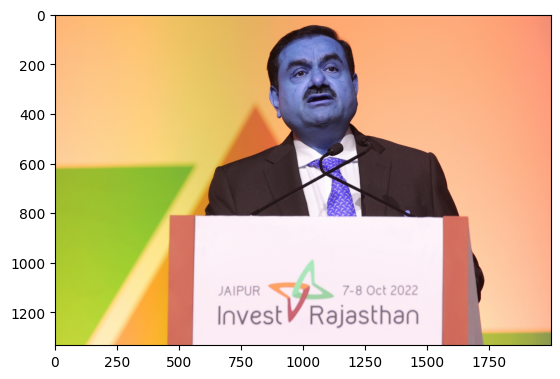

In [2]:
path_to_imgs = "/Dataset/"
path_to_test = "/Test_images/"
# print(os.getcwd() + path_to_test)

color_img = cv2.imread(os.getcwd() + path_to_test + "9b5469c18751002ada0d9181309377a2.jpg")
print(color_img.shape)
plt.imshow(color_img)

(1333, 2000)


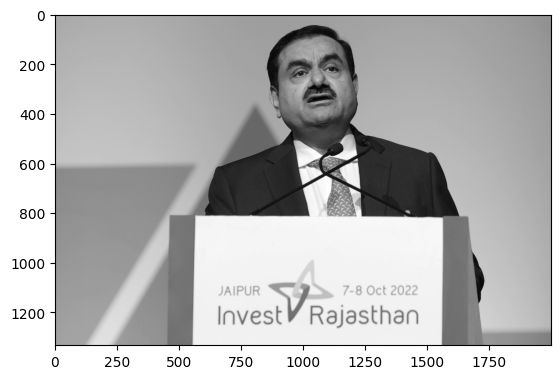

In [3]:
gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
print(gray_img.shape)
plt.imshow(gray_img, cmap="gray")

In [4]:
path_to_haar_clf = "/Opencv/haarcascades/"
face_clf = cv2.CascadeClassifier(os.getcwd() + path_to_haar_clf + "haarcascade_frontalface_default.xml")
eye_clf = cv2.CascadeClassifier(os.getcwd() + path_to_haar_clf + "haarcascade_eye.xml")

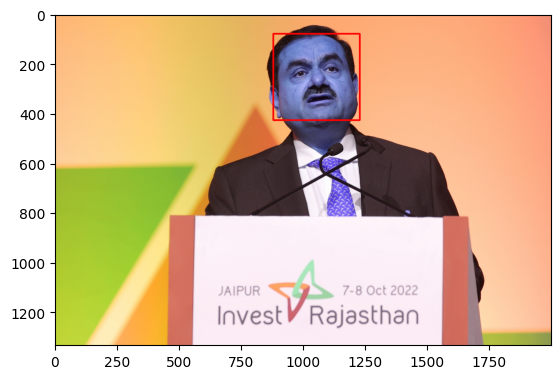

In [5]:
face_loc = face_clf.detectMultiScale(color_img,1.3,5)
(x,y,w,h) = face_loc[0]
color_face = cv2.rectangle(color_img,(x,y),(x+w,y+h),(255,0,0),5)
plt.imshow(color_face)

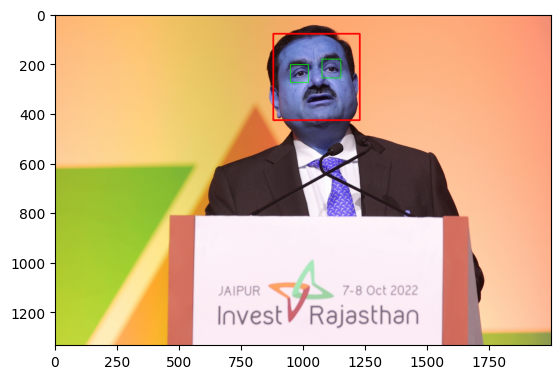

In [6]:
for (x,y,w,h) in face_loc:
    face_detected = cv2.rectangle(color_img,(x,y),(x+w,y+h),(255,0,0),5)
    c_face = face_detected[y:y+h,x:x+w]
    g_face = gray_img[y:y+h,x:x+w]
    eye_loc = eye_clf.detectMultiScale(g_face)
    for (x_e,y_e,w_e,h_e) in eye_loc:
        eye_detected = cv2.rectangle(c_face,(x_e,y_e),(x_e+w_e,y_e+h_e),(0,255,0),2)

plt.figure()
plt.imshow(face_detected, cmap="gray")
plt.show()

In [7]:
# %matplotlib inline

# plt.imshow(c_face, cmap='gray')

In [8]:
# cropped_img = np.array(c_face)
# cropped_img.shape

### ii. To get a cropped image if 2 eyes are seen in an image

In [9]:
def get_a_cropped_img_if_both_eyes(img_path):
    img = cv2.imread(img_path)
    g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces_loc = face_clf.detectMultiScale(g_img, 1.2, 3)
    for (x,y,w,h) in faces_loc:
        c_face = img[y:y+h,x:x+h]
        g_face = g_img[y:y+h,x:x+h]
        eyes_loc = eye_clf.detectMultiScale(g_face)
        if len(eyes_loc) >= 2:
            return c_face

In [10]:
# img_1 = cv2.imread(os.getcwd() + path_to_test + "9b5469c18751002ada0d9181309377a2.jpg")
# plt.imshow(img_1)

# cropped_img = get_a_cropped_img_if_both_eyes(os.getcwd() + path_to_test + "9b5469c18751002ada0d9181309377a2.jpg")
# plt.imshow(cropped_img)

### iii. Create a cropped dataset for each leader

#### - Path for each leader subdir in dataset 

In [11]:
subdir_paths = []
for subdir in os.scandir(os.getcwd() + path_to_imgs):
    if subdir.is_dir():
        subdir_paths.append(subdir.path)        
# subdir_paths

#### - Create a folder for all cropped images

In [12]:
import shutil

path_to_cr_imgs = "/Dataset/Cropped_data/"
if os.path.exists(os.getcwd() + path_to_cr_imgs): # checks if "Cropped_data" folder exists
    shutil.rmtree(os.getcwd() + path_to_cr_imgs) # removes the folder if it exists
os.mkdir(os.getcwd() + path_to_cr_imgs) # creates a new folder name "Cropped_data"

#### - Iterate through each image to get cropped images

#### --> Iterate through each of the image dictionary --> crop images and have them store in separate leader_name folders --> rename imgs and have them store in cropped_img_rename_dict, leader_name as a key and multiple rename_img_paths as value --> save cropped imgs as an image in a cropped_folder/leader using cv2.imwrite()

In [15]:
import re
import imghdr

cropped_img_dirs = []
cropped_img_rename_dict = {}
ext_ = []

for subdir in subdir_paths:
    leader = subdir.split("/")[-1]
    cropped_img_rename_dict[leader] = []
    counter = 1
#     print(leader)
    
    for img_path in os.scandir(subdir):
        if imghdr.what(img_path) is not None:
            ext = img_path.path.split(".")[-1]
            ext_.append(ext)

            cropped_img = get_a_cropped_img_if_both_eyes(img_path.path)
            if cropped_img is not None and cropped_img.shape[0] != 0 and cropped_img.shape[1] != 0:
                cropped_folder = os.getcwd() + path_to_cr_imgs + leader
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_img_dirs.append(cropped_folder)
#                     print("Generating cropped images of", leader, "in folder: ",cropped_folder)

                cropped_img_rename = leader + str(counter) + ".png"
                cropped_img_rename_path = cropped_folder + "/" + cropped_img_rename
            
                cv2.imwrite(cropped_img_rename_path, cropped_img) ## Saving the imgs in cropped_data folder using imwrite()
# # #                 print(os.listdir(cropped_img_rename_path))
                cropped_img_rename_dict[leader].append(cropped_img_rename_path)
                counter += 1

# list(set(ext_))        

IsADirectoryError: [Errno 21] Is a directory: '/Users/saylinarkhede/Documents/2023/LeadersClassifier/Model/Dataset/Cropped_data/elon_musk'

### iv. Feature Engineering (feature extraction) using wavelet transform

In [14]:
import numpy as np
import pywt
import cv2    

def w2d(color_img, mode='haar', level=1):
    imArray = color_img
    
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    imArray =  np.float32(imArray)   
    imArray /= 255;
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H